# Diet Recommendation System - Model Training

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, hamming_loss

# Load the dataset
file_path = "diet_plans_updated.csv"
df = pd.read_csv(file_path)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Diet Type', 'Breakfast', 'Lunch', 'Dinner']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalize numerical features
scaler = StandardScaler()
numeric_cols = ['Calories', 'Protein', 'Calcium', 'Fats']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Save encoders & scaler
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoders, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [2]:

# Clustering (Goal-Based Recommendation)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df[numeric_cols])

# Classification (Input-Based Recommendation)
X = df[['Calories', 'Protein', 'Calcium', 'Fats']]
y = df[['Breakfast', 'Lunch', 'Dinner']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Wrap RandomForestClassifier inside MultiOutputClassifier
rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


In [3]:

# Accuracy evaluation for each label
for i, col in enumerate(y_test.columns):
    acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {col}: {acc}")

# Compute Hamming loss for each label separately and take the mean
hamming_losses = [
    hamming_loss(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])
]
avg_hamming_loss = np.mean(hamming_losses)

print("Average Hamming Loss:", avg_hamming_loss)


Accuracy for Breakfast: 0.10666666666666667
Accuracy for Lunch: 0.09666666666666666
Accuracy for Dinner: 0.08333333333333333
Average Hamming Loss: 0.9044444444444445


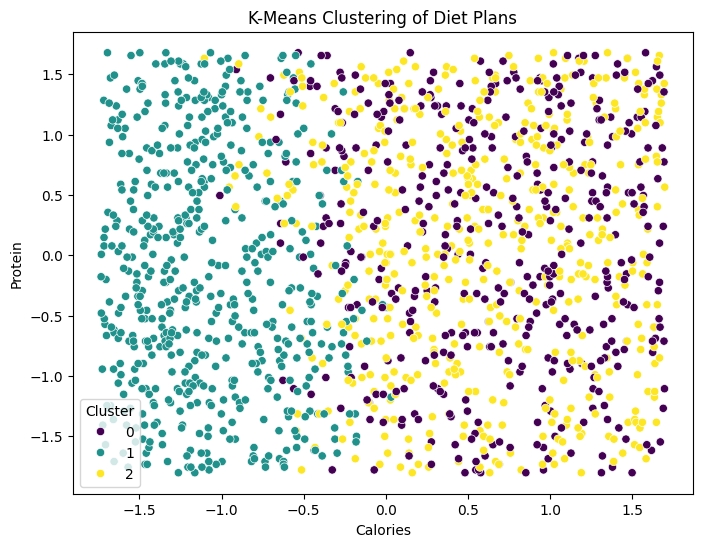

In [5]:

# Save models
with open("diet_clustering.pkl", "wb") as f:
    pickle.dump(kmeans, f)
with open("diet_classifier.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Calories'], y=df['Protein'], hue=df['Cluster'], palette='viridis')
plt.title("K-Means Clustering of Diet Plans")
plt.xlabel("Calories")
plt.ylabel("Protein")
plt.show()
